In [1]:
import glob2
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
files = glob2.glob("train/*")
species = []
for f in files:
    species.append(f[6:]) # birds species list

Definition to create array of bird species catalogues

In [3]:
def get_species_dataset(directory, species_count = None, img_count = None):
                                # reduced number of species and images per specie
    target = []

    zero = glob2.glob(os.path.join(directory, species[0])+"/*")[0]
    zero_img = cv2.cvtColor(cv2.imread(zero),cv2.COLOR_BGR2RGB).reshape(1,224,224,3)

    for specie in species[:species_count]:
        specie_id = species.index(specie)
        specie_imgs = glob2.glob(os.path.join(directory, specie)+"/*")

        for img in specie_imgs[:img_count]:
            tmp_img = cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB).reshape(1,224,224,3)
            
            if specie == species[0] and img == specie_imgs[0]:
                dataset = zero_img
                
            else:
                dataset = np.concatenate((dataset, tmp_img ), axis=0)

            target.append(specie_id)
            
    target_arr = np.array(target).reshape(-1,1)

    print("            dataset shape:", dataset.shape)
    print("             target shape:", target_arr.shape)
    print("target classes and counts:", dict((i, target.count(i)) for i in target))

    return dataset, target_arr

In [4]:
len(species)

400

Dataset for DL training

In [5]:
x_train, y_train = get_species_dataset("train", 10)

            dataset shape: (1534, 224, 224, 3)
             target shape: (1534, 1)
target classes and counts: {0: 166, 1: 180, 2: 179, 3: 137, 4: 146, 5: 137, 6: 130, 7: 133, 8: 161, 9: 165}


In [6]:
x_test, y_test = get_species_dataset("test", 10)

            dataset shape: (50, 224, 224, 3)
             target shape: (50, 1)
target classes and counts: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5}


In [7]:
import tensorflow as tf

In [8]:
from tensorflow.keras import layers
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD 

def create_cnn_model(inShape, convNum, hNum,hAct, outNum, loss, seed, lr):
    """
    :param inShape: kształt wejścia, h*w*c
    :param convNum: lista ilości featerów w warstwach konwolucyjnych
    :param hNum: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param hAct: rodzaj aktywacji w warstwach ukrytych, str
    :param outNum: ilość
    :param loss: funkcja kosztu
    """

    
    # pusty model
    model = tf.keras.Sequential()
    # warstwa wejściowa
    model.add(layers.InputLayer(input_shape=(inShape)))
    # warstwy konwolucyjne
    for idx, oneConvNum in enumerate(convNum):
        # dodajemy kolejną warstwę konwolucyjną
        # zmienia nam ilość cech(kanałów) na oneConvNum
        model.add(layers.Conv2D(
                                    filters=oneConvNum,
                                    kernel_size=4,
                                    strides=2,
                                    padding="SAME",
                                    activation="relu"
                                    )
                                )
        # doajemy następującego po convie maxpool'a
        # zmniejsza nam wymiarowość HxW o połowę
        model.add(layers.MaxPool2D(
                                    pool_size=(2, 2),
                                    strides=2,
                                    padding="SAME"
                                    )
                                )
        # model.add(Dropout(0.2))
    # spłaszczamy po konwolucjach, przygotowanie pod relu
    model.add(layers.Flatten())
    # warstwy fully connected
    for idx, oneHidNum in enumerate(hNum):
        # dodajemy warstwę
        model.add(layers.Dense(oneHidNum, activation=hAct))
        model.add(Dropout(0.6))
      # warstwy fully connected
    # warstwa wyjściowa
    model.add(layers.Dense(outNum))
    # warstwa softmax, dystrybucja prawdopodobieństwa
    model.add(layers.Softmax())
    print(model.summary())
    
    opt = tf.keras.optimizers.Adam()
   
    
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy"]
    )
    
    return model

In [9]:
our_cnn = create_cnn_model(
    inShape=(224, 224, 3),
    convNum=[32,64,128,256],
    hNum=[],
    hAct='relu',
    outNum=10,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    seed = 42,
    lr = 0.01
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [10]:
history = our_cnn.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, y_test)
)

Epoch 1/10
24/24 [==============================] - 7s 271ms/step - loss: 8.7442 - accuracy: 0.1578 - val_loss: 1.7278 - val_accuracy: 0.4200
Epoch 2/10
24/24 [==============================] - 6s 260ms/step - loss: 1.6993 - accuracy: 0.4211 - val_loss: 1.2566 - val_accuracy: 0.6200
Epoch 3/10
24/24 [==============================] - 6s 264ms/step - loss: 1.1294 - accuracy: 0.6173 - val_loss: 0.9142 - val_accuracy: 0.7000
Epoch 4/10
24/24 [==============================] - 6s 263ms/step - loss: 0.8725 - accuracy: 0.6936 - val_loss: 0.5216 - val_accuracy: 0.8600
Epoch 5/10
24/24 [==============================] - 6s 271ms/step - loss: 0.5383 - accuracy: 0.8188 - val_loss: 0.5482 - val_accuracy: 0.8000
Epoch 6/10
24/24 [==============================] - 6s 260ms/step - loss: 0.3501 - accuracy: 0.8846 - val_loss: 0.5575 - val_accuracy: 0.8000
Epoch 7/10
24/24 [==============================] - 6s 268ms/step - loss: 0.2025 - accuracy: 0.9316 - val_loss: 0.3487 - val_accuracy: 0.8800
Epoch 

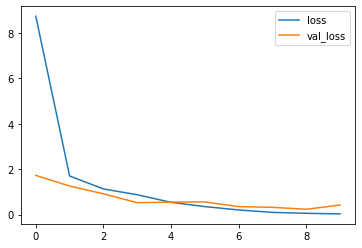

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show()

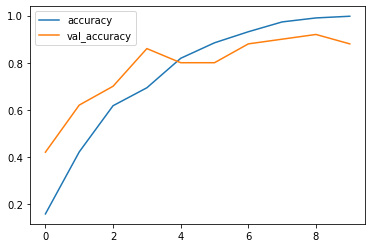

In [13]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [18]:
our_cnn.save_weights("weights/model_for_fun_AK")

In [20]:
# our_cnn.predict(x_test[:2])

    inShape=(224, 224, 3),
    convNum=[8,16,24,32,40],
    hNum=[],
    hAct='relu',
    outNum=5,
    loss=tf.keras.losses.SparseCategoricalCrossentropy()

In [16]:
model_loaded = create_cnn_model(
    inShape=(224, 224, 3),
    convNum=[32,64,128,256],
    hNum=[],
    hAct='relu',
    outNum=10,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    seed = 42,
    lr = 0.01
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      1568      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        32832     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
y_pred = model_loaded.predict(x_test)
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.09      0.60      0.15         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         5
           9       0.50      0.40      0.44         5

    accuracy                           0.10        50
   macro avg       0.06      0.10      0.06        50
weighted avg       0.06      0.10      0.06        50



C:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\andrz\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
y_pred = model_loaded.predict(x_test)
print(confusion_matrix(y_test, y_pred.argmax(axis=1)))

[[0 0 4 1 0 0 0 0 0 0]
 [0 0 4 1 0 0 0 0 0 0]
 [0 0 3 1 0 0 0 1 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 2 0 0]
 [0 0 3 0 0 0 0 0 0 2]
 [0 0 4 1 0 0 0 0 0 0]
 [0 0 3 2 0 0 0 0 0 0]
 [0 0 3 2 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 1 0 2]]


In [20]:
model_loaded.load_weights("weights/model_for_fun_AK")

In [21]:
y_pred = our_cnn.predict(x_test)
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.60      0.75         5
           2       0.50      0.80      0.62         5
           3       1.00      0.60      0.75         5
           4       1.00      0.80      0.89         5
           5       0.83      1.00      0.91         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           0.88        50
   macro avg       0.92      0.88      0.88        50
weighted avg       0.92      0.88      0.88        50



In [ ]:
model_loaded.predict(x_test[:2])

In [ ]:
our_cnn.save("model/simple.h5")

In [ ]:
model_loaded_h5 = tf.keras.models.load_model("model/simple.h5")

In [ ]:
y_pred = model_loaded_h5.predict(x_test)
print(classification_report(y_test, y_pred.argmax(axis=1)))

In [ ]:
model_loaded_h5.predict(x_test[:2])